# Data Preprocessing
 - Load Excel file into a Pandas dataframe
 - Filter out slabs that were replaced at any time (the slabs with the state 'R')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('..\spreadsheet_data\i16WB_filtered.csv')
# Filter out slabs that were replaced during time period
df = df[df['Replaced'].notnull() == False]
df = df[df['Replaced and Broken'].notnull() == False]
df = df[df['2014'] != 'R']

df = df.drop(columns=['Replaced', 'Replaced and Broken', 'Interstate', 'Direction', 'Year Replaced', 'Possibly OR'])
df.head()

,MP From,MP To,2014 Slab ID,BY Length (ft),2014,2015,2016,2017,2018
0,22.000000,21.997566,3,12.85,NC,NC,NC,NC,NC
1,21.997566,21.994286,4,17.32,NC,NC,NC,NC,NC
2,21.994286,21.991244,5,16.06,NC,NC,NC,NC,NC
3,21.991244,21.987169,6,21.52,NC,NC,NC,NC,NC
4,21.987169,21.982809,7,23.02,NC,NC,NC,NC,NC


To better organize the data, the slabs were categorized into what milemarker they fit into. A slab is defined to be in a milemarker $m$, where $m$ is a positive integer, if the starting position of the slab is between $(m - 1, m]$. Since the data was taken in the westbound direction, a certain milemarker $m$ contains the slabs that start between milemarkers $m$ and $m - 1$.

40 transition probability matrices (TPM) were made using the data from each milemarker (MM 22-13). For each milemarker, a TPM was calculated for the years 2014-2015, 2015-2016, 2016-2017, and 2017-2018. The TPMs were calculated by:
 - Counting the number of a particular transition seen for each possible transition between a given two years $y-1$ and $y$
 - Finding the percentage that a slab in state $s_0$ would transition into slab state $s_1$ by dividing by the row total

 ![Alt text](..\images\image.png)

Tables with the slab states reported in aggregate for a particular year and mile were also calculated for future analysis.


In [2]:
#Grouping data by mile marker (every mile). Data will be put into bins with (m, m + 1] where m is an integer and a mile marker.
 
def group_by_mile(df, start, end):
    df_by_mile = {}
    for i in range(end, start, -1):
        mile_df = df[(df['MP From'] <= i) & (df['MP From'] > i - 1)]
        df_by_mile[i] = mile_df
        
        
    return df_by_mile

def create_TPM_by_mile(df_by_mile, mile_start, mile_end, year_start, year_end):
    TPMs = {}
    for mile in range(mile_end, mile_start, -1):
        for year in range(year_start + 1, year_end + 1):
            # Creates a df with the number of slabs that transition from each of the one states to another
            TPM = df_by_mile[mile].groupby([str(year - 1), str(year)]).size().unstack()
            # Reindex so that the rows and columns so that the upper triangluar shape can take form
            TPM = TPM.reindex(['NC', 'L1', 'T1', 'L2', 'T2', 'CC', 'SS'])
            TPM = TPM.reindex(['NC', 'L1', 'T1', 'L2', 'T2', 'CC', 'SS'], axis=1)
            TPM = TPM.fillna(0)
            # Calculate percentages
            TPM = TPM.div(TPM.sum(axis=1), axis=0).round(3)
            TPM = TPM.fillna(0)
            # a TPM can be accessed by the milemarker and the year, where the transition happens from year-1 to year.   
            TPMs[(mile, year)] = TPM
    return TPMs


df_by_mile = group_by_mile(df, 12, 22)
df_by_mile_aggregate = {}
TPMs = create_TPM_by_mile(df_by_mile, 12, 22, 2014, 2018)


## What is the percentage of NCs that transition to another state?
There are two things to explore:
 - if over time, the rate of NCs transitioning out increases
 - if the rate of NCs transitioning out is related to the percentage of slabs currently destroyed for a given milemarker

To explore the first question, a line graph can be made. The rate of NCs transitioning out (in other words, the rate that the NCs are getting destroyed) is defined as:

$P_{NC, L1} + P_{NC, T1} + P_{NC, L2} + P_{NC, T2} + P_{NC, CC} + P_{NC, SS} = 1 - P_{NC, NC}$

,22,21,20,19,18,17,16,15,14,13
2015,0.038,0.037,0.024,0.047,0.069,0.052,0.054,0.029,0.033,0.038
2016,0.027,0.038,0.012,0.049,0.074,0.086,0.042,0.013,0.009,0.040
2017,0.036,0.035,0.017,0.040,0.102,0.067,0.049,0.030,0.026,0.052
2018,0.024,0.027,0.013,0.036,0.076,0.007,0.017,0.009,0.036,0.022


<AxesSubplot:title={'center':'Percentage of NC slabs that transition to damaged states over time'}, xlabel='Time', ylabel='Percent Change from NC to Damaged'>

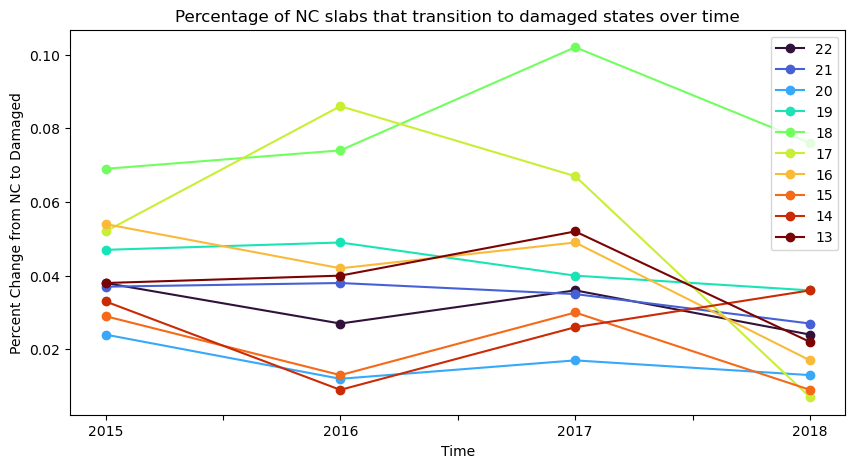

In [5]:
def calc_NC_to_damaged(mile, year):
    return 1 - TPMs[(mile, year)].loc['NC', 'NC']

table = {}

for mile in range(22, 12, -1):
    table[mile] = []
    for year in range(2015, 2019):
        table[mile].append(calc_NC_to_damaged(mile, year))




NC_to_damaged = pd.DataFrame(table)
NC_to_damaged.index = ['2015', '2016', '2017', '2018']

display(NC_to_damaged)
NC_to_damaged.plot(use_index=True, marker='o', title='Percentage of NC slabs that transition to damaged states over time', colormap='turbo', figsize=(10, 5), ylabel='Percent Change from NC to Damaged', xlabel='Time')



Conclusions: Overall, there was no significant trend in the change of rate from NC to damaged for the first three years when looking at the line charts as a whole. However, there is a noticiable decrease in the rate of number of slabs transitioning out for the years 207-2018 for all milemarkers but one.

## Another Question: Is the percentage change from NC to Damaged related to the percentage of slabs damaged?
Ordered pairs were made by delegating the $x$-value to be the percentage of slabs damaged for a given year and milemarker and the $y$ value to be the percentage of NC slabs that transtioned to a worse state for a given year and milemarker. These 40 points were plottted on a scatterplot and a linear regression analysis was conducted.

,Percent Damaged,Percentage of NC that Transitioned to Damaged
0,0.187,0.038
1,0.218,0.027
2,0.239,0.036
3,0.266,0.024
4,0.189,0.037


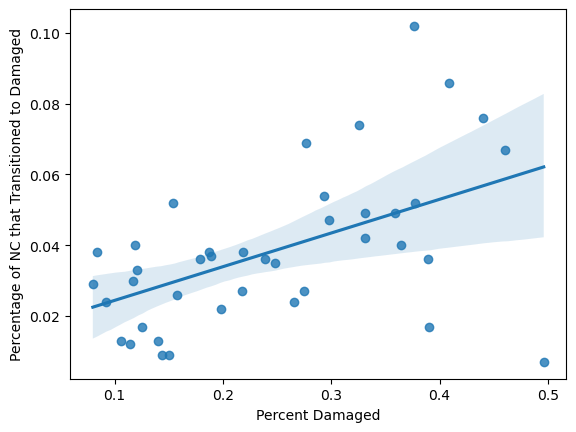

In [11]:
def pair_values():
    rate_of_damage_vs_damage = {'Percent Damaged' : [], 'Percentage of NC that Transitioned to Damaged' : []}
    for mile in range(22, 12, -1):
        for year in range(2015, 2019): 
            freq = pd.crosstab(df_by_mile[mile][str(year - 1)], 'count')
            freq['relative freq'] = freq['count'] / freq['count'].sum()
            percent_damaged = (1 - freq.loc['NC', 'relative freq']).round(3)
            rate_of_damage = NC_to_damaged.loc[str(year), mile]
            rate_of_damage_vs_damage['Percent Damaged'].append(percent_damaged)
            rate_of_damage_vs_damage['Percentage of NC that Transitioned to Damaged'].append(rate_of_damage)
    return pd.DataFrame(rate_of_damage_vs_damage)

rate_of_damage_vs_damage = pair_values()
display(rate_of_damage_vs_damage.head())

sns.regplot(x='Percent Damaged', y='Percentage of NC that Transitioned to Damaged', data=rate_of_damage_vs_damage, scatter=True)

rate_of_damage_vs_damage.to_csv('..\spreadsheet_data\\rate_of_damage_vs_damage.csv')


Equation of the best fit line: $y = 0.0953x + 0.0149$

$R^2$ value: $0.2647$

Based on the $R^2$ value and the positive best fit line, there is a weak, positive correlation between the percent slabs that were damaged and the percent of NC slabs that transition to damaged in a span of a year.